En este notebook voy a hacer el primer acercamiento a la información de ecobici

In [1]:
import requests # to access websites
import csv # to read and write .csv files
from bs4 import BeautifulSoup # for 'scrapping' information from websites
import os # to do operative sistem acctions like writting files
from urllib.parse import urljoin # to join partial url's
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd # to graph on maps
import contextily as ctx
import scipy

/mnt/c/Users/david.martindelcampo/Documents/proyecto_ecobici/virtual_environment/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
#function to download all .csv files from a website
#requests get the raw information, BeautifulSoup gives order to the information
def download_csv(url,folder):
    response = requests.get(url) # retrive all the info of the url (get raw info)
    if response.status_code == 200: # the status 200 means successfull request
        soup = BeautifulSoup(response.content,'html.parser') # parse/analyze the website content (order info)
        links = soup.find_all('a',href=True) #a means anchor in html, which refers to hyperlinks.
        ### in this part i filter for only 2023 files
        csvs = [link['href'] for link in links if link['href'].endswith('.csv') and '2023' in link['href']] #href refers to the 'www.(...).com' direction of an hyperlink
        ###
        if not os.path.exists(folder):
            os.makedirs(folder) #if the download folder doesnt exits, we create it
        for csv in csvs:
            full_csv = urljoin(url,csv) # csv's have the partial direction, with urljoin we complete it.
            file_name = full_csv.split('/')[-1] # the last part of the href is the file name
            file_path = os.path.join(folder, file_name) # join creates a valid filepath, joining various parts of the direction
            csv_response = requests.get(full_csv) # download the .csv file
            if csv_response.status_code == 200:
                with open(file_path,'wb') as file: #'with open' opens a file to do anything with it (like saving it)
                    file.write(csv_response.content) # we write the file content in file_path
                print(f"{file_name} downloaded")
            else:
                print(f"error downloading {file_name}")
    else:
        print(f'error accessing website {url}')

In [3]:
url = 'https://ecobici.cdmx.gob.mx/datos-abiertos/'
folder = 'data'
#download_csv(url,folder)

In [4]:
csvs = [os.path.join(folder,entry) for entry in os.listdir(folder) if entry.endswith('.csv')]
df = pd.read_csv(csvs[0])
for csv in csvs[1:]:
    df = pd.concat([df,pd.read_csv(csv)],ignore_index=True)

In [5]:
subdf = df.sample(10000).copy().reset_index(drop = True)
subdf['datetime_retiro'] = pd.to_datetime(subdf['Fecha_Retiro'].str.cat(subdf['Hora_Retiro'], sep=' '),format = '%d/%m/%Y %H:%M:%S')
subdf['datetime_arribo'] = pd.to_datetime(subdf['Fecha Arribo'].str.cat(subdf['Hora_Arribo'], sep=' '),format = '%d/%m/%Y %H:%M:%S')
subdf['Bici'] = subdf['Bici'].astype(str)
subdf['duracion_viaje[h]'] = (subdf.datetime_arribo - subdf.datetime_retiro).apply(lambda x: x.total_seconds())/3600
subdf['dia_semana'] = subdf['datetime_retiro'].dt.dayofweek
subdf['hora_retiro'] = subdf['datetime_retiro'].dt.hour

In [6]:
subdf.head(10)
#subdf.info(show_counts=True)
#subdf.describe().T

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha Arribo,Hora_Arribo,datetime_retiro,datetime_arribo,duracion_viaje[h],dia_semana,hora_retiro
0,F,26.0,3788213,005,25/07/2023,16:19:49,553,25/07/2023,16:32:34,2023-07-25 16:19:49,2023-07-25 16:32:34,0.212500,1,16
1,M,34.0,6768493,468,21/02/2023,09:47:58,130,21/02/2023,10:04:19,2023-02-21 09:47:58,2023-02-21 10:04:19,0.272500,1,9
2,M,42.0,7383862,080,30/12/2023,21:41:11,047,30/12/2023,22:00:30,2023-12-30 21:41:11,2023-12-30 22:00:30,0.321944,5,21
3,M,32.0,2401123,305,30/10/2023,18:58:45,285,30/10/2023,19:04:11,2023-10-30 18:58:45,2023-10-30 19:04:11,0.090556,0,18
4,M,20.0,3273026,552,31/08/2023,15:25:30,545,31/08/2023,15:29:54,2023-08-31 15:25:30,2023-08-31 15:29:54,0.073333,3,15
5,F,30.0,8671893,117,11/07/2023,09:45:26,214,11/07/2023,10:25:11,2023-07-11 09:45:26,2023-07-11 10:25:11,0.662500,1,9
6,M,43.0,6016299,136,09/11/2023,18:52:21,442,09/11/2023,19:26:01,2023-11-09 18:52:21,2023-11-09 19:26:01,0.561111,3,18
7,M,30.0,6055115,011,29/09/2023,16:41:57,043,29/09/2023,16:55:10,2023-09-29 16:41:57,2023-09-29 16:55:10,0.220278,4,16
8,M,23.0,5217351,111,30/01/2023,19:19:27,031,30/01/2023,19:29:55,2023-01-30 19:19:27,2023-01-30 19:29:55,0.174444,0,19
9,M,27.0,8704140,354,15/05/2023,19:53:47,288,15/05/2023,20:06:10,2023-05-15 19:53:47,2023-05-15 20:06:10,0.206389,0,19


<Axes: xlabel='Genero_Usuario'>

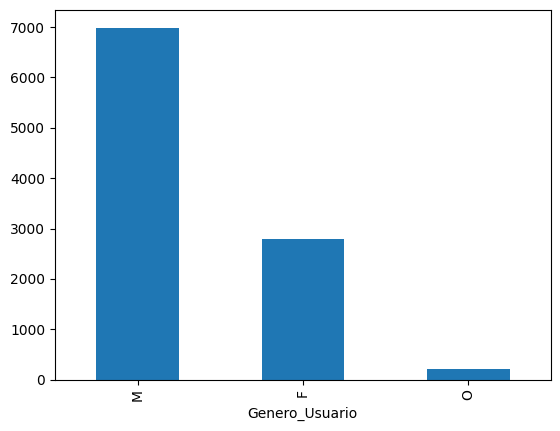

In [7]:
subdf['Genero_Usuario'].value_counts().plot.bar()

In [8]:
subdf.groupby(by=['Genero_Usuario'])['duracion_viaje[h]'].mean()

Genero_Usuario
F    0.278986
M    0.574207
O    0.257451
Name: duracion_viaje[h], dtype: float64

<Axes: xlabel='duracion_viaje[h]', ylabel='Count'>

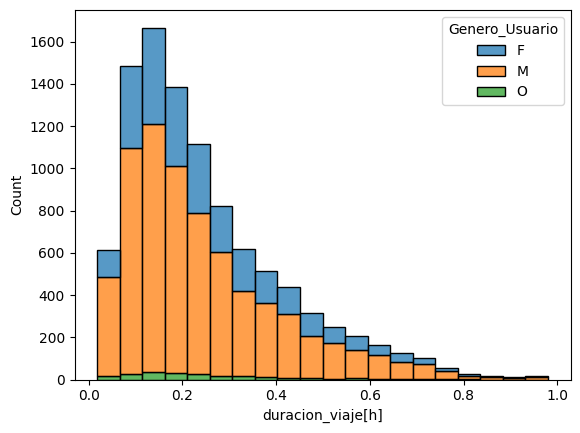

In [9]:
sns.histplot(subdf[subdf['duracion_viaje[h]'] < 1],x='duracion_viaje[h]',bins=20,hue='Genero_Usuario',multiple='stack')
#hacerlo en seaborn

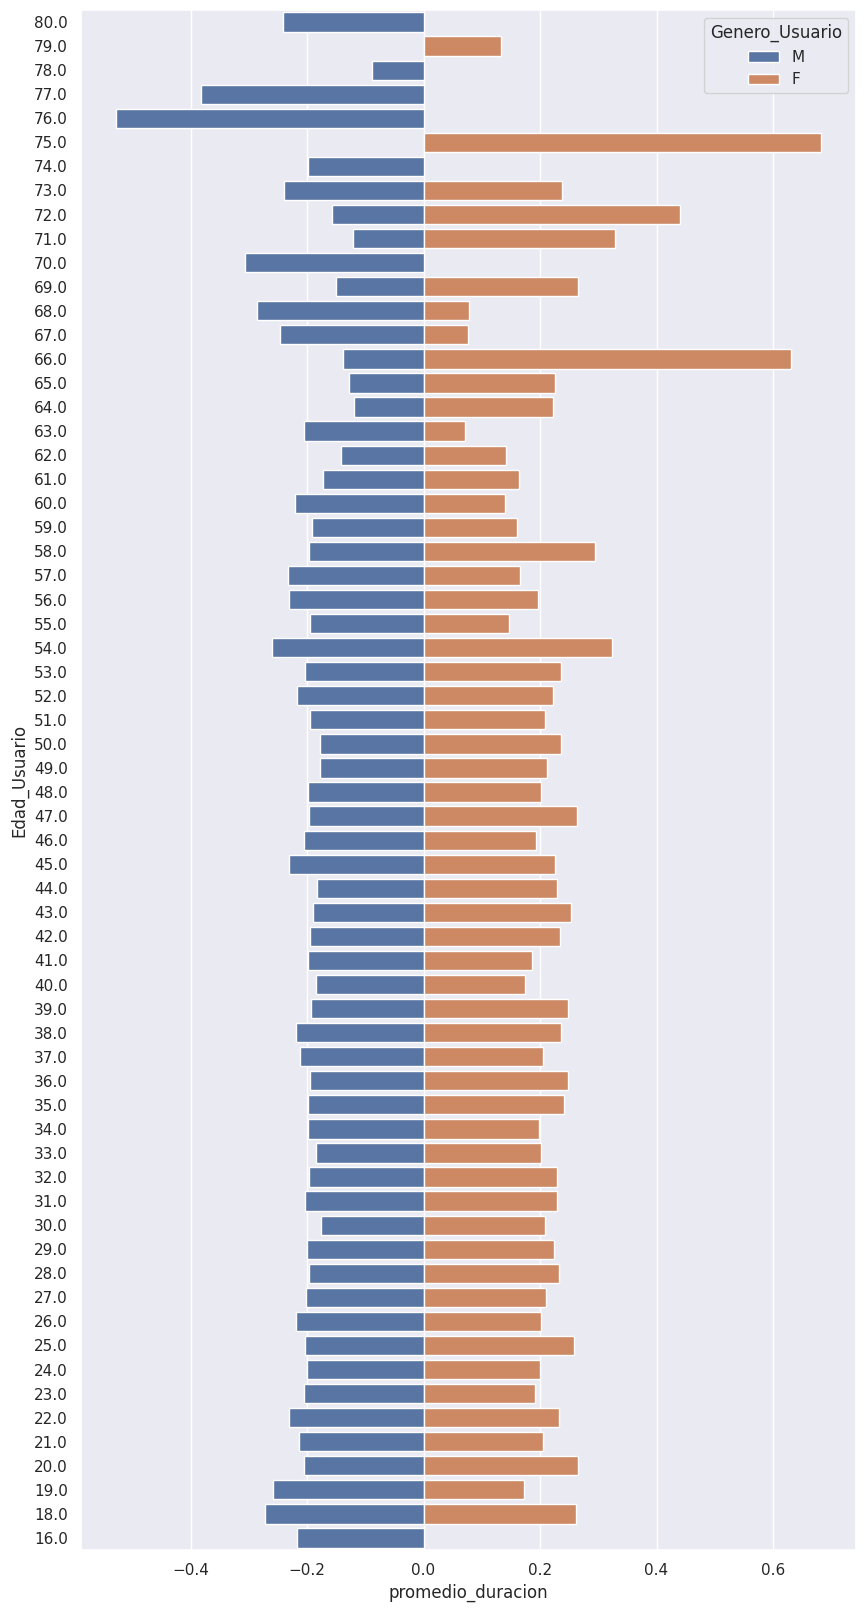

In [10]:
pyramid_graph_info = subdf[((subdf['Genero_Usuario'] =='M')|(subdf['Genero_Usuario'] =='F'))].groupby(['Genero_Usuario','Edad_Usuario'])['duracion_viaje[h]'].median().reset_index()
pyramid_graph_info.rename(columns = {'duracion_viaje[h]':'promedio_duracion'},inplace = True)
pyramid_graph_info.loc[pyramid_graph_info[pyramid_graph_info['Genero_Usuario'] == 'M'].index,'promedio_duracion'] = pyramid_graph_info[pyramid_graph_info['Genero_Usuario'] == 'M']['promedio_duracion']*-1
pyramid_graph_info
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.barplot(data = pyramid_graph_info, x = 'promedio_duracion',y='Edad_Usuario',hue='Genero_Usuario',orient='horizontal',dodge=False)
plt.gca().invert_yaxis()

In [11]:
# heatmat hora vs día de la semana
# sacar ubicaciones de las estaciones
# subir a github
# series de tiempo datetime
# preguntarle a chatGPT
# investigar que ya hay hecho

<Axes: xlabel='dia_semana', ylabel='hora_retiro'>

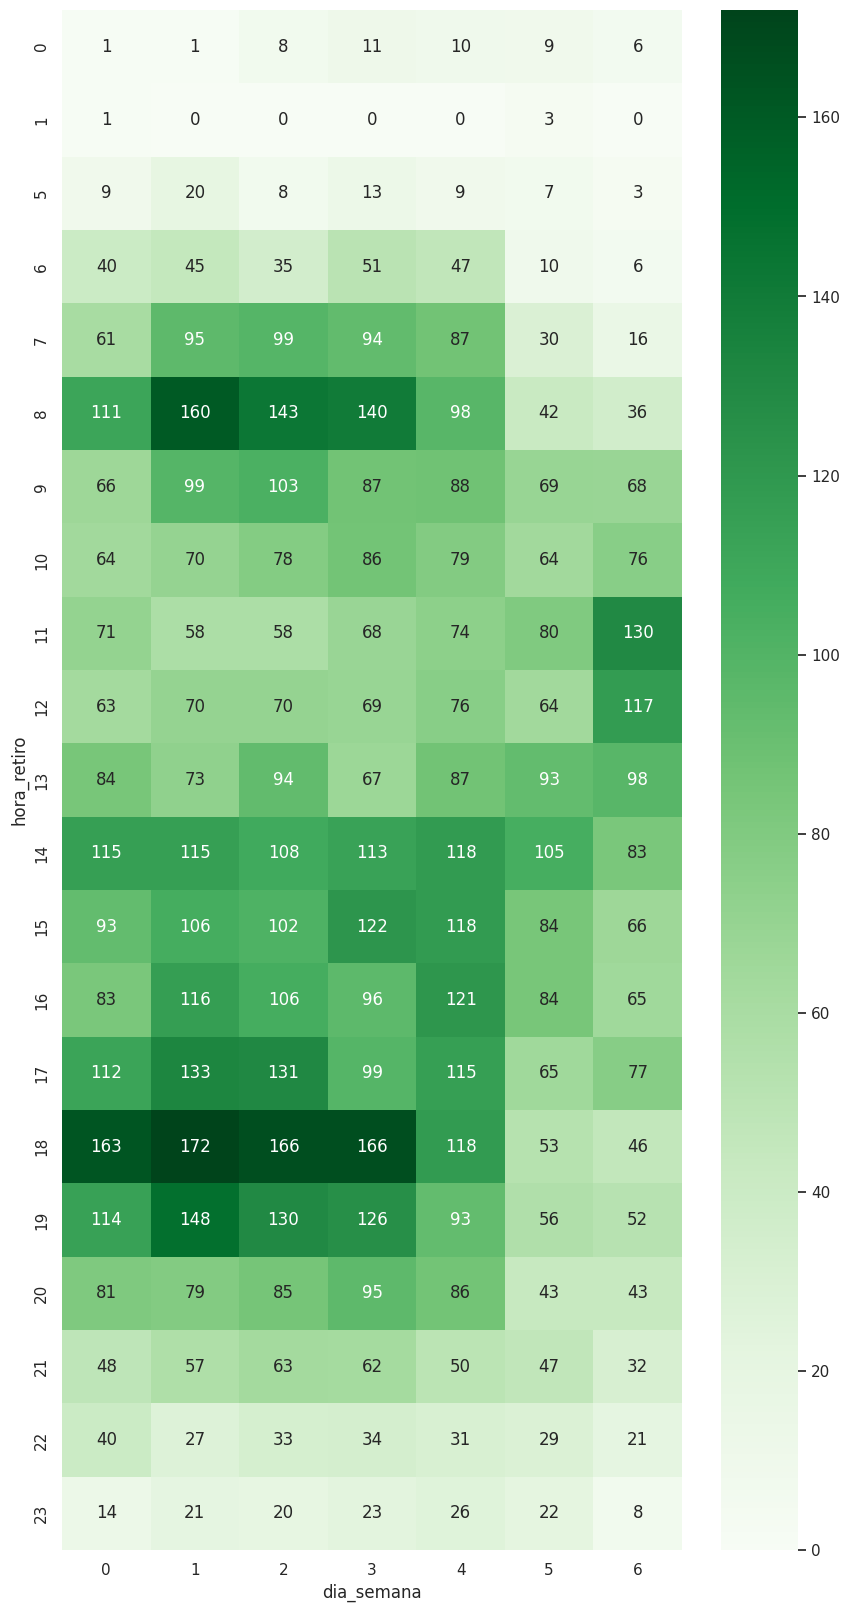

In [12]:
heatmap_info = subdf.pivot_table(values='Bici',index = 'hora_retiro',columns='dia_semana',aggfunc='count',fill_value = 0)
sns.heatmap(heatmap_info,cmap='Greens',annot=True,fmt='g')

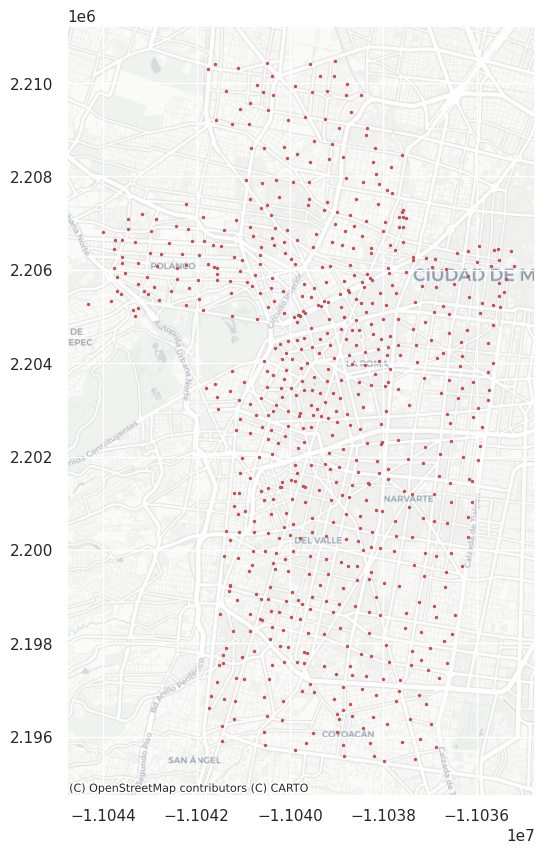

In [13]:
estaciones = gpd.read_file('data/cicloestaciones_ecobici/cicloestaciones_ecobici.shp')
estaciones = estaciones.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10,10))
estaciones.plot(ax=ax,color = 'r',markersize=2)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
plt.show()